In [1]:
import tensorflow as tf

numT=4
sz=50
numNODES=43712
numRLN=7

O_SHAPE=(numNODES,numT,4)
#P,vx,vy,reyn
RA_SHAPE=(numNODES,numRLN,3)
#x,y,faceLen
RR_SHAPE=(numNODES,numRLN)

In [2]:
class MPNN_Class:
    
    def FCN(self,inputS,outputS,layerN,name=None):
    #a basic 3 layer fully connected module
        inputL= tf.keras.Input(shape=(inputS))
        x=tf.keras.layers.Dense(layerN,activation=tf.nn.elu)(inputL)
        x=tf.keras.layers.Dense(layerN,activation=tf.nn.elu)(x)
        x=tf.keras.layers.Dense(outputS,activation=tf.nn.elu)(x)
        return tf.keras.Model(inputs=[inputL],outputs=[x],name=name)

    def encoder(self,inputS,outputS,layerN):
        #modularised time encoder module
        inputL= tf.keras.Input(shape=(inputS))
        x=self.FCN(inputS[1],outputS,layerN)(inputL)
        x=tf.keras.layers.Conv1D(layerN,inputS[0])(x)
        return tf.keras.Model(inputs=[inputL],outputs=[x])
    
    def encoder_block(self,layerN):
        O=tf.keras.Input(shape=(O_SHAPE[1:]),name='O')
        Ra=tf.keras.Input(shape=(RA_SHAPE[1:]),name='Ra')
        #create encoders
        V_encoder=self.encoder([numT, 4],layerN,layerN)
        E_encoder=self.FCN(RA_SHAPE[1:],layerN,layerN)

        #encoded
        V=tf.squeeze(V_encoder(O),axis=1)
        E=E_encoder(Ra)

        return tf.keras.Model(inputs=[O,Ra],outputs=[V,E],name='InputEncoder')
    
    def GNCore(self,layerN,num):
        V=tf.keras.Input(shape=(layerN),name='V')
        E=tf.keras.Input(shape=(RA_SHAPE[1],layerN),name='E')
        Rr=tf.keras.Input(shape=(RR_SHAPE[1:]),name='Rr',dtype=tf.int32)

        #form Vrr
        Vrr=tf.gather(V,Rr)
        Ecat=tf.keras.layers.concatenate([E,Vrr])

        #create update functions
        phiE=self.FCN([RA_SHAPE[1],layerN*2],layerN,layerN)
        phiO=self.FCN([O_SHAPE[1],layerN*2],layerN,layerN)
        e=phiE(Ecat)
        ek=tf.reduce_sum(e,axis=1,keepdims=False)
        ek=tf.keras.layers.concatenate([V,ek])
        Vp=phiO(ek)

        return tf.keras.Model(inputs=[V,E,Rr],outputs=[Vp,e],name='GNCore'+str(num))
    
    def __init__(self, layerN=32,num_msg_pass=4,share_GNCore=False):

        O=tf.keras.Input(shape=(O_SHAPE[1:]),name='O')
        Ra=tf.keras.Input(shape=(RA_SHAPE[1:]),name='Ra')
        Rr=tf.keras.Input(shape=(RR_SHAPE[1:]),name='Rr',dtype=tf.int32)

        #create individual models
        encoder=self.encoder_block(layerN)
        decoder=self.FCN(layerN,3,layerN,'decoder')
        GNC=[]
        for x in range(num_msg_pass):
            GNC.append(self.GNCore(layerN,x))
        if (share_GNCore):
            GNC=[GNC[0]]*(x+1)
        #first, encode
        V,E=encoder([O,Ra])

        #then, process
        for x in range(num_msg_pass):
            V,E=GNC[x]([V,E,Rr])

        #finally, decode
        Vp=decoder(V)
        P=tf.keras.layers.add([O[:,-1,:-1],Vp*1e-5*sz],name='output')

        self.model= tf.keras.Model(inputs=[O,Ra,Rr],outputs=[P])

In [3]:
test=MPNN_Class(num_msg_pass=10,share_GNCore=True)


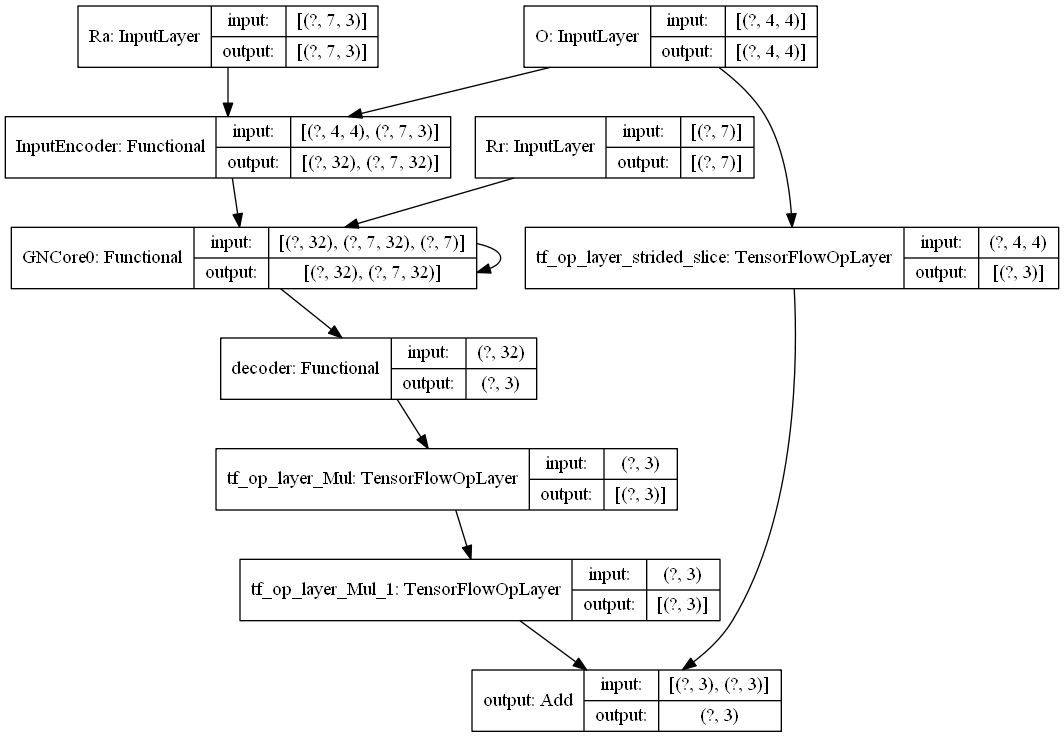

In [4]:

tf.keras.utils.plot_model(test.model,show_shapes=True,to_file='./assets/model.png')

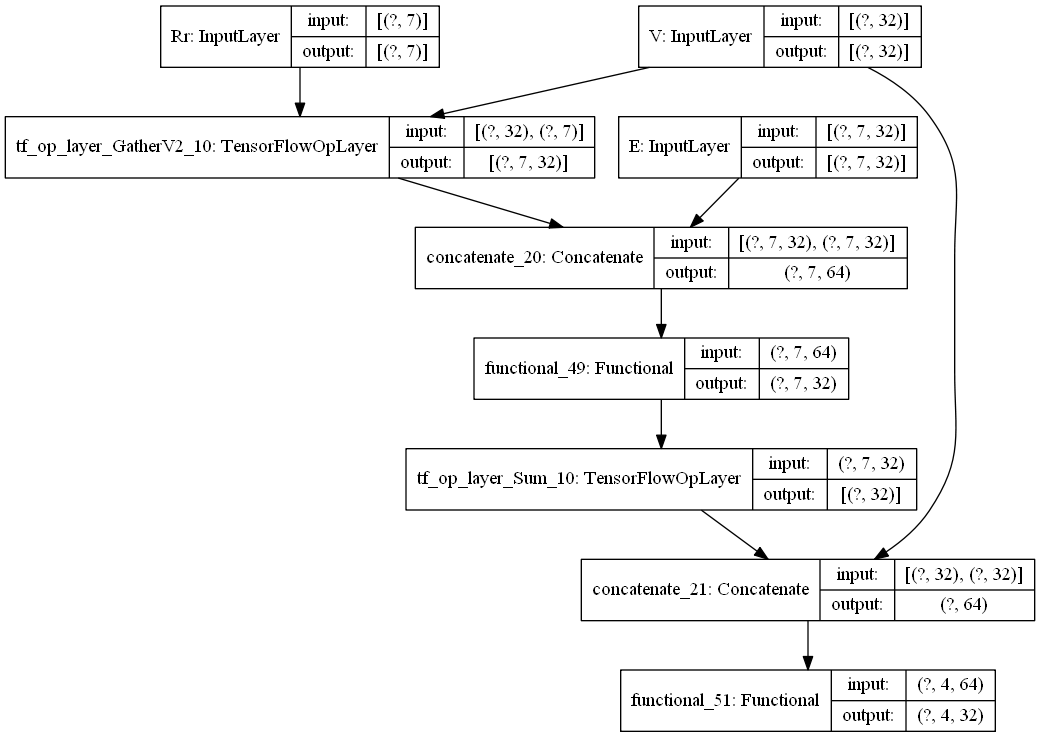

In [5]:
tf.keras.utils.plot_model(test.GNCore(32,0),show_shapes=True,to_file='./assets/GNCore.png')

In [6]:
test.model.summary()

Model: "functional_47"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
O (InputLayer)                  [(None, 4, 4)]       0                                            
__________________________________________________________________________________________________
Ra (InputLayer)                 [(None, 7, 3)]       0                                            
__________________________________________________________________________________________________
InputEncoder (Functional)       [(None, 32), (None,  8640        O[0][0]                          
                                                                 Ra[0][0]                         
__________________________________________________________________________________________________
Rr (InputLayer)                 [(None, 7)]          0                                

In [7]:
GNC=[]
for x in range(4):
    GNC.append(test.GNCore(32,x))

In [8]:
GNC

In [9]:
x

3

In [10]:
x=[[1,2],[2,3]]

In [11]:
import numpy as np
numTime=int(500)
randtS=np.random.choice(range(1,10000), numTime, replace=False)
randtS=randtS*10

splitIdx=int(numTime/10)
path=np.array(["air",'oil','lowreyn'])

params=[]
val_params=[]
for x in path:
    for timeStep in randtS:
        params.append([x,timeStep])
    

In [12]:
np.random.shuffle(params)

In [13]:
params

[['air', 27980],
 ['oil', 68380],
 ['oil', 53440],
 ['air', 45740],
 ['air', 29710],
 ['oil', 3900],
 ['lowreyn', 17230],
 ['lowreyn', 80950],
 ['air', 77930],
 ['air', 18040],
 ['air', 6860],
 ['oil', 73590],
 ['air', 87200],
 ['air', 39640],
 ['lowreyn', 85520],
 ['oil', 21410],
 ['air', 4910],
 ['lowreyn', 70620],
 ['lowreyn', 24540],
 ['air', 52990],
 ['air', 51830],
 ['oil', 62330],
 ['oil', 87280],
 ['air', 11160],
 ['air', 53610],
 ['lowreyn', 62220],
 ['lowreyn', 44620],
 ['lowreyn', 65300],
 ['air', 73410],
 ['lowreyn', 72030],
 ['lowreyn', 93290],
 ['oil', 73410],
 ['air', 29660],
 ['lowreyn', 75720],
 ['air', 56900],
 ['lowreyn', 78460],
 ['lowreyn', 76390],
 ['oil', 87510],
 ['air', 62700],
 ['lowreyn', 52430],
 ['lowreyn', 45790],
 ['oil', 17690],
 ['oil', 48130],
 ['air', 96620],
 ['oil', 66090],
 ['lowreyn', 89530],
 ['air', 2830],
 ['lowreyn', 32730],
 ['lowreyn', 36970],
 ['oil', 47820],
 ['air', 25040],
 ['oil', 12540],
 ['lowreyn', 78210],
 ['oil', 58320],
 ['oil', 7